# Revenue Prediction via CLV by Machine Learning

In the previous section, we've cleaned and wrangled the data for the prediction. Now in this section we will utilize the models of machine learning (ML). The prediction will be implemented with backtesting. Here are the steps: 

* We will call a function of `get_rfm_features()` for several periods, with base total transaction of six months (`2009-12-01` to `2010-12-01`). In this case, we're predicting the revenue for every 2 months (9-1 = 8 tests in total)

* We will save the calculation for each period in a DataFrame, and use it for prediction in the next periods. Keep in mind that the features we're using are the calculation of RFM, which can change for each period. 

* We'll calculate the accuracy by comparing the real and predicted target revenue in each periods, and lastly we'll average it to find the model accuracy. 

In [1]:
# !pip install scikit-lego

In [2]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# pip install XGBoost

In [4]:
# pip install lightgbm

In [5]:
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, cross_val_score)

from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

# Connecting model for both classification 
# and regression in zero-inflated dataset
from sklego.meta import ZeroInflatedRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
df = pd.read_csv('online_retail_II_cleaned.csv')

In [7]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
820417,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
820418,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
820419,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
820420,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [8]:
# Set the read format in float numbers
pd.options.display.float_format = '{:.4f}'.format

# Cutting the dates for time features

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['date'] = pd.to_datetime(df['InvoiceDate'].dt.date)
df['time'] = df['InvoiceDate'].dt.time

df['hour'] = df['time'].apply(lambda x: x.hour)
df['weekend'] = df['date'].apply(lambda x: x.weekday() in [5, 6])
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)

In [9]:
## Recalling the function from previous section

### Some modification: 

## We'll modify the reset_index() to combine all the data later on

# and we're changing the datatypes of date inputs to datetime64[ns]
# so that we can add the date with 1 for target_start

from typing import Union

def get_rfm_features(
    df: pd.DataFrame, 
    feature_start: Union[str, pd.DatetimeIndex], 
      feature_end: Union[str, pd.DatetimeIndex], 
     target_start: Union[str, pd.DatetimeIndex], 
       target_end: Union[str, pd.DatetimeIndex]
):
    
    ## Separating the orders based on the date:
    df_features_period = df.loc[(df['date'] >= feature_start) &
                                (df['date'] <= feature_end)]
    
    print(f'''Taking RFM values for features: \n{feature_start} to {feature_end} -- {(
        pd.to_datetime(feature_end) - pd.to_datetime(feature_start)).days} days''')
    
    print(f'''to predict target revenue: \n{target_start} to {target_end} -- {(
        pd.to_datetime(target_end) - pd.to_datetime(target_start)).days} days''')
    
    ## Getting the features:
    features = df_features_period.groupby('Customer ID').agg(
            # new_column_name = ('agg_col', 'agg_func')
                      recency = ('date', lambda x: (pd.to_datetime(feature_end) - x.max()).days),
                    frequency = ('revenue', lambda x: x.loc[x > 0].count()),
#               returns_count = ('revenue', lambda x: x.loc[x < 0].count()),
                            T = ('date', lambda x: (x.max() - x.min()).days),
               monetary_value = ('revenue', 'sum'),
               total_quantity = ('Quantity', lambda x: x.loc[x > 0].sum()),
#                total_return = ('Quantity', lambda x: x.loc[x < 0].sum() * -1),
         purchase_hour_median = ('hour', lambda x: x.median()),
            purchase_hour_dow = ('dayofweek', lambda x: x.median()),
        purchase_weekend_prop = ('weekend', 'mean')
    ).reset_index()   
    
    # Filter negative `monetary_value` (and also `avg_basket_value`) to 0
    features.loc[features['monetary_value'] < 0, 'monetary_value'] = 0    
    
    features['avg_basket_value'] = features['monetary_value'] / features['frequency']
    features['avg_basket_size']  = features['total_quantity'] / features['frequency']
    
    ## There's data with `frequency == 0`, so we'll fill in the gaps.
    features      = features.replace([-np.inf, np.inf], np.nan)
    
    ## Make the target data:
    target_data = df.loc[(df['date'] >= target_start) &
                         (df['date'] <= target_end)]

    # Target feature 1: `is_returned`
    features['is_returned'] = np.where(
        features['Customer ID'].isin(target_data['Customer ID']), 1, 0
    )
    
    # Target feature 2: `target_rev`
    target_rev = (target_data.groupby('Customer ID')['revenue']
                      .sum().rename('target_rev').reset_index())
    
    features = features.merge(target_rev, how='left', on='Customer ID').fillna(0)

    ## Clean negative values in `target_rev`; 
    ## Some customers go back after 2 months just to return items.
    features.loc[features['target_rev'] < 0, ['is_returned', 'target_rev']] = [0, 0]
    
    return features

In [10]:
# Check the function
features = get_rfm_features(
    df, '2009-12-01', '2010-06-01', '2006-12-06', '2011-06-06')

Taking RFM values for features: 
2009-12-01 to 2010-06-01 -- 182 days
to predict target revenue: 
2006-12-06 to 2011-06-06 -- 1643 days


In [11]:
features

,Customer ID,recency,frequency,T,monetary_value,total_quantity,purchase_hour_median,purchase_hour_dow,purchase_weekend_prop,avg_basket_value,avg_basket_size,is_returned,target_rev
0,12346,91,6,74,28.0500,6,13.0000,1.0000,0.0000,4.6750,1.0000,1,169.3600
1,12349,33,46,146,1044.3700,473,13.0000,3.0000,0.0000,22.7037,10.2826,1,2196.9900
2,12355,11,22,0,488.2100,303,11.0000,4.0000,0.0000,22.1914,13.7727,1,947.6100
3,12358,175,17,0,1429.8300,309,7.0000,1.0000,0.0000,84.1076,18.1765,1,2519.0100
4,12359,50,66,128,1428.2300,777,13.0000,2.0000,0.4571,21.6398,11.7727,1,5929.2900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,18281,21,10,0,120.3200,92,10.0000,1.0000,0.0000,12.0320,9.2000,1,120.3200
2730,18283,65,132,37,354.4200,173,13.0000,4.0000,0.4621,2.6850,1.3106,1,1174.8700
2731,18285,104,11,0,377.0000,144,10.0000,2.0000,0.0000,34.2727,13.0909,1,377.0000
2732,18286,167,16,0,412.9500,113,10.0000,2.0000,0.0000,25.8094,7.0625,1,1138.4300


## Recall: Data Wrangling into Periods for ML Prediction

On the previous section `03-feature-engineering`, we've accumulated all the data, with `rfm_period` as an identifier. The data is specified as below:

* `rfm_period == 0` means the data's taken on a whole six month (`2009-12-01` to `2010-05-31`, and also the target revenue's calculated within the next two months (`2010-06-01` to `2010-08-01`)

* As the `rfm_period` increases, the time will shift every two months, so the RFM value will renew; either from a new transaction or not returning.

    * Take `rfm_period == 1`with
        * training data of `2010-02-01` to `2010-07-31` and 
        * target revenue calculated from `2010-08-01` to `2011-10-01`,
    * Move on to `rfm_period == 2` with 
        * training data of `2010-04-01` to `2010-09-30` and 
        * target revenue calculated from `2010-10-01` to `2010-12-01`,
    * and so on until it reaches the end of transaction in `2011-12-09`.

In [12]:
periods  = ['2009-12-01', '2010-02-01', '2010-04-01', '2010-06-01', 
            '2010-08-01', '2010-10-01', '2010-12-01', '2011-02-01', 
            '2011-04-01', '2011-06-01', '2011-08-01', '2011-10-01', '2011-12-09']
            ## Last date (09 instead of 01) being last day of transaction. 
    
def accumulate_data(df, periods):
    
    periods = pd.to_datetime(periods, format='%Y-%m-%d')

    total_data = pd.DataFrame()
    
    for i, date in zip(range(8), periods):
        
        rfm_features = get_rfm_features(df, 
            periods[i]  , periods[i+3] - pd.Timedelta(days=1), 
            periods[i+3], periods[i+4])
        rfm_features['rfm_period'] = i
        
        total_data = pd.concat([total_data, rfm_features], ignore_index=True, sort=False)

    # Adjust the column positions: `rfm_period`, features, label
    total_data = total_data[ ['rfm_period'] + 
        [col for col in total_data.columns if col != 'rfm_period'] ]
    
    return total_data

In [13]:
whole_data = accumulate_data(df, periods)

Taking RFM values for features: 
2009-12-01 00:00:00 to 2010-05-31 00:00:00 -- 181 days
to predict target revenue: 
2010-06-01 00:00:00 to 2010-08-01 00:00:00 -- 61 days
Taking RFM values for features: 
2010-02-01 00:00:00 to 2010-07-31 00:00:00 -- 180 days
to predict target revenue: 
2010-08-01 00:00:00 to 2010-10-01 00:00:00 -- 61 days
Taking RFM values for features: 
2010-04-01 00:00:00 to 2010-09-30 00:00:00 -- 182 days
to predict target revenue: 
2010-10-01 00:00:00 to 2010-12-01 00:00:00 -- 61 days
Taking RFM values for features: 
2010-06-01 00:00:00 to 2010-11-30 00:00:00 -- 182 days
to predict target revenue: 
2010-12-01 00:00:00 to 2011-02-01 00:00:00 -- 62 days
Taking RFM values for features: 
2010-08-01 00:00:00 to 2011-01-31 00:00:00 -- 183 days
to predict target revenue: 
2011-02-01 00:00:00 to 2011-04-01 00:00:00 -- 59 days
Taking RFM values for features: 
2010-10-01 00:00:00 to 2011-03-31 00:00:00 -- 181 days
to predict target revenue: 
2011-04-01 00:00:00 to 2011-06-01 

In [14]:
whole_data

,rfm_period,Customer ID,recency,frequency,T,monetary_value,total_quantity,purchase_hour_median,purchase_hour_dow,purchase_weekend_prop,avg_basket_value,avg_basket_size,is_returned,target_rev
0,0,12346,90,6,74,28.0500,6,13.0000,1.0000,0.0000,4.6750,1.0000,1,142.3100
1,0,12349,32,46,146,1044.3700,473,13.0000,3.0000,0.0000,22.7037,10.2826,0,0.0000
2,0,12355,10,22,0,488.2100,303,11.0000,4.0000,0.0000,22.1914,13.7727,0,0.0000
3,0,12358,174,17,0,1429.8300,309,7.0000,1.0000,0.0000,84.1076,18.1765,1,268.1000
4,0,12359,49,66,128,1428.2300,777,13.0000,2.0000,0.4571,21.6398,11.7727,1,489.8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24336,7,18273,126,1,0,51.0000,20,11.0000,6.0000,1.0000,51.0000,20.0000,1,102.0000
24337,7,18280,146,10,0,180.6000,45,9.0000,0.0000,0.0000,18.0600,4.5000,0,0.0000
24338,7,18281,49,7,0,80.8200,54,10.0000,6.0000,1.0000,11.5457,7.7143,0,0.0000
24339,7,18283,17,297,136,768.8200,518,13.0000,3.0000,0.0000,2.5886,1.7441,1,130.9000


In [15]:
whole_data.describe().T

,count,mean,std,min,25%,50%,75%,max
rfm_period,24341.0000,3.5227,2.2075,0.0000,2.0000,4.0000,5.0000,7.0000
Customer ID,24341.0000,15324.1009,1700.2936,12346.0000,13861.0000,15303.0000,16797.0000,18287.0000
recency,24341.0000,63.6779,51.8604,0.0000,18.0000,52.0000,103.0000,183.0000
frequency,24341.0000,61.4619,114.9094,0.0000,15.0000,32.0000,69.0000,3304.0000
T,24341.0000,52.3596,60.0054,0.0000,0.0000,21.0000,106.0000,183.0000
monetary_value,24341.0000,1282.5121,4598.3053,0.0000,252.8400,516.1300,1128.1500,164699.0700
total_quantity,24341.0000,814.2763,3613.6183,0.0000,129.0000,292.0000,675.0000,220596.0000
purchase_hour_median,24341.0000,12.6307,2.2192,7.0000,11.0000,13.0000,14.0000,20.0000
purchase_hour_dow,24341.0000,2.5602,1.7783,0.0000,1.0000,2.0000,4.0000,6.0000
purchase_weekend_prop,24341.0000,0.1408,0.3010,0.0000,0.0000,0.0000,0.0000,1.0000


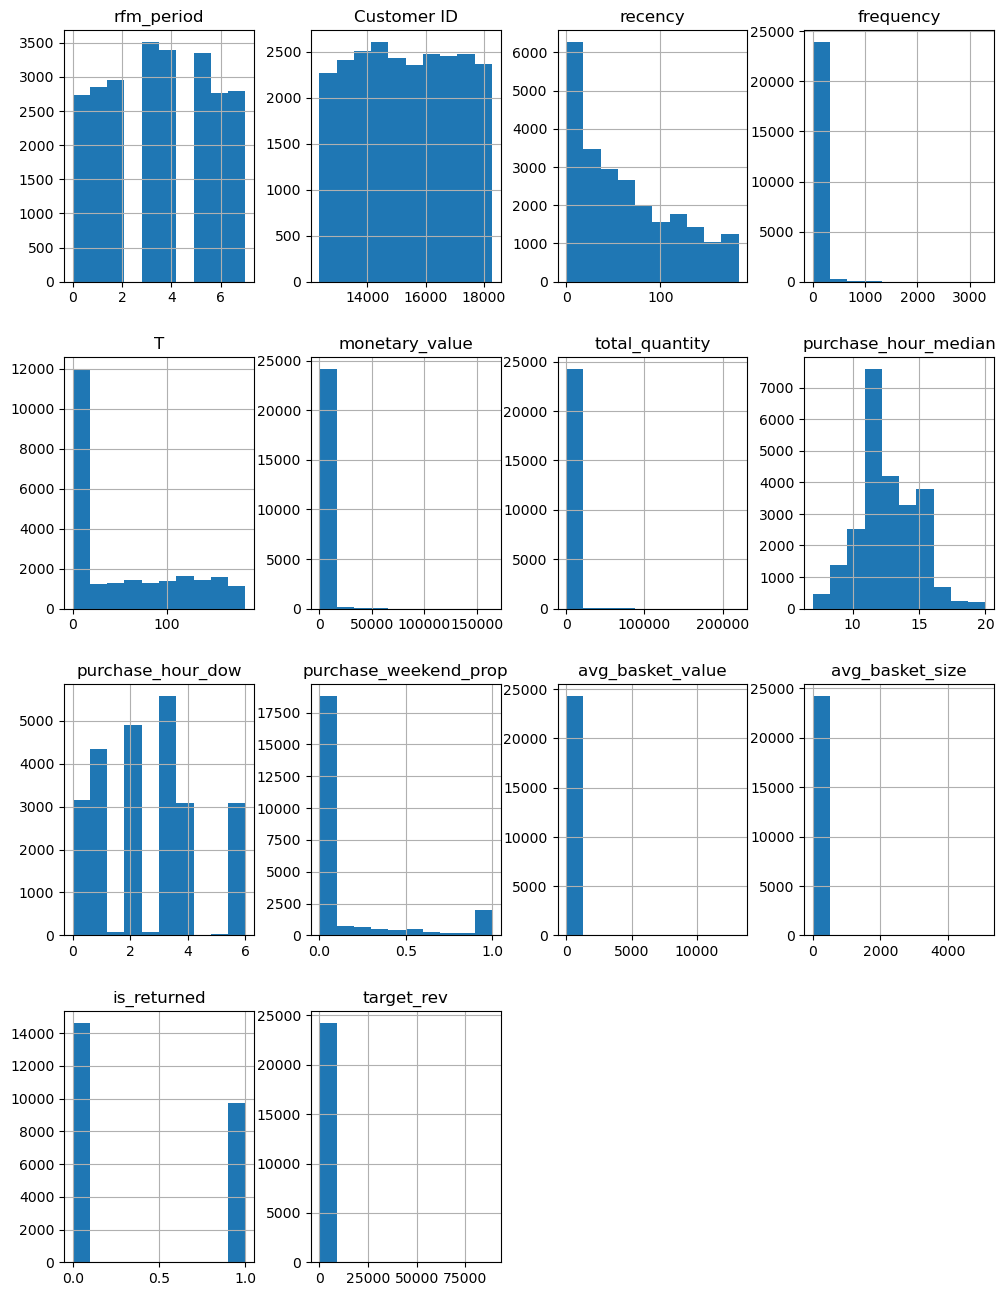

In [16]:
whole_data.hist(figsize=(12,16))
plt.show()

It would be pretty hard if we only predict the revenues directly. We need to predict first if the customer will return. In this section, we'll be using two types of prediction: **(1) returning customers and (2) their target revenues**.

## Prediction of Returning Customers and its Revenue 

For both predictions on machine learning, we'll first use `RandomizedSearchCV` on the first four periods (`0 <= rfm_period <= 3`) to find the best parameters or settings of the model. After that, we'll use it to predict both values on all periods, from `0-7`; `is_returned` and `log_target_rev`. The result will be:

$$Predicted Revenue = P(classification) * value(regression)$$

We will gather both predictions in a DataFrame, and then count the metrics. Here we're utilizing coefficient of determination (R^2) to see the performance.

In [17]:
# Predictions of `X_test, y_test` start at `rfm_period == 0`
predictions_list = pd.DataFrame(
    whole_data.loc[whole_data['rfm_period'] >= 0, 
        ['rfm_period', 'Customer ID', 'is_returned']]
)

In [18]:
predictions_list

,rfm_period,Customer ID,is_returned
0,0,12346,1
1,0,12349,0
2,0,12355,0
3,0,12358,1
4,0,12359,1
...,...,...,...
24336,7,18273,1
24337,7,18280,0
24338,7,18281,0
24339,7,18283,1


### Function 1: Grid Backtesting

In [19]:
## MODIFIED: Accuracy count separately; classification and then regression
def grid_backtesting(df, grid_classifier, grid_regressor):
    '''
        Function to do cross-validation with given model of grid parameters
        (`RandomizedSearchCV` or `GridSearchCV`) for `rfm_period` 0-3 (4 periods),
        
        then fitting the best parameters to dataset with `rfm_period` 4-8 (3 periods)
        for both in classification and regression. For the combinations, we'll
        multiply the predicted_revenue = Probability(Class) * Value(Reg), 
        afterwards we compare the predicted_revenue to real values, 
        find the R2 score on each iterations, and lastly average it out.      
    '''
    
    grid_best_params_classifier = {}
    grid_best_scores_classifier = {}
    
    grid_best_params_regressor = {}
    grid_best_scores_regressor = {}
    
    acc_results = []
    r2_results = []
    hurdle_results = []
    
    ## Make a copy of IDs and labels so that we can add predictions result later on.
    model_predictions = df.loc[df['rfm_period'] >= 1, 
        ['rfm_period', 'Customer ID', 'is_returned', 'target_rev']]
    
    print(f'Cross-validation for classification and regression:\n')
    print(f'{grid_classifier}\n\n{grid_regressor}\n')
    
    ## Cross-validation: Period 0-3
    for n_period in range(0, 4):
        
        mask_val = (df['rfm_period']  <= n_period)
        mask_reg = (df['is_returned'] == 1)
        
        print(f'rfm_period {n_period+1}/4:')
        
        X_val_class, y_val_class = (
            df.loc[mask_val, df.columns[2:-2]],
            df.loc[mask_val, df.columns[-2]  ])

        X_val_reg, y_val_reg = (
            df.loc[mask_val & mask_reg, df.columns[2:-2]],
            df.loc[mask_val & mask_reg, df.columns[-1]  ])
        
        ## Classification -- Predict customers that will return 
        grid_classifier.fit(X_val_class, y_val_class)
        
        grid_best_params_classifier[n_period+1] = grid_classifier.best_estimator_
        grid_best_scores_classifier[n_period+1] = grid_classifier.best_score_
        
        ## Regression: Predict revenues of returned customer
        grid_regressor.fit(X_val_reg, y_val_reg)
        
        grid_best_params_regressor[n_period+1] = grid_regressor.best_estimator_
        grid_best_scores_regressor[n_period+1] = grid_regressor.best_score_
    
    print('\nBest params for the model: \n')
    print(f'Classifier:\n{grid_best_params_classifier[4]}\nAccuracy: {grid_best_scores_classifier[4]}\n')
    print(f'Regressor:\n{grid_best_params_regressor[4]}\nAccuracy: {grid_best_scores_regressor[4]}\n')
    
    print('Cross-validation done!\n')
                
    print('Fitting best parameters into the next periods:')
    used_model_classifier     = grid_best_params_classifier[4]
    used_model_regressor      = grid_best_params_regressor[4]

    
    ## Fit the data into best parameters for both types of models:
    for n_period in range(0, 7):

        mask_train = (df['rfm_period'] <= n_period)
        mask_test  = (df['rfm_period'] == n_period + 1)
        mask_reg   = (df['is_returned'] == 1)
        
        print(f'rfm_period {n_period+1}/7:')
        
        X_train_class, y_train_class = (
            df.loc[mask_train, df.columns[2:-2]],
            df.loc[mask_train, df.columns[-2]  ])
        X_test_class, y_test_class   = (
            df.loc[mask_test, df.columns[2:-2]],
            df.loc[mask_test, df.columns[-2]  ]) 

        X_train_reg, y_train_reg = (
            df.loc[mask_train & mask_reg, df.columns[2:-2]],
            df.loc[mask_train & mask_reg, df.columns[-1]  ])
        X_test_reg, y_test_reg   = (
            df.loc[mask_test  & mask_reg, df.columns[2:-2]],
            df.loc[mask_test  & mask_reg, df.columns[-1]  ]) 

        ## Classification -- Predict customers that will return 
        used_model_classifier.fit(X_train_class, y_train_class)

        ## Regression: Predict revenues of returned customer
        used_model_regressor.fit(X_train_reg, y_train_reg)
        
        # Some conditionals on different ensemble models (not all has `predict_proba`):

## MODIFY TO GET THE PREDICT_PROBA AND APPLY HURDLE MODELS EVALUATION

        # Put the classifier prediction into respective `rfm_period`
        model_predictions.loc[mask_test, 'class_pred'] = (
            used_model_classifier.predict(X_test_class))

        # Put the classifier prediction into respective `rfm_period`
        model_predictions.loc[mask_test, 'class_pred_proba'] = (
            used_model_classifier.predict_proba(X_test_class)[:,1])

        # Regression results: Return
        model_predictions.loc[mask_test &  mask_reg, 'reg_pred'] = (
            used_model_regressor.predict(X_test_reg))

        # Treatment for others: Put it as zero
        model_predictions.loc[mask_test & ~mask_reg, 'reg_pred'] = 0

        # Calculate the predicted revenue
        model_predictions.loc[mask_test, 'predicted_rev'] = (
            model_predictions.loc[mask_test, 'class_pred_proba'] *
            model_predictions.loc[mask_test, 'reg_pred']
        )

        acc_results.append(accuracy_score(
            model_predictions.loc[mask_test, 'is_returned'],
            model_predictions.loc[mask_test, 'class_pred']
        ))

        r2_results.append(r2_score(
            model_predictions.loc[mask_test & mask_reg, 'target_rev'], 
            model_predictions.loc[mask_test & mask_reg, 'reg_pred']
        ))

        
        hurdle_results.append(r2_score(
            model_predictions.loc[mask_test & mask_reg, 'target_rev'], 
            model_predictions.loc[mask_test & mask_reg, 'predicted_rev']
        ))
          
    print('Prediction done!')
    
    acc_avg    = np.mean(acc_results)
    r2_avg     = np.mean(r2_results)
    hurdle_avg = np.mean(hurdle_results)
    
    print(f'Classification accuracy: {acc_avg}')
    print(f'Regression accuracy: {r2_avg}')
    print(f'Class + Reg R2 Score -- Hurdle Models: {hurdle_avg}')

    return acc_avg, r2_avg, hurdle_avg, model_predictions

### Function 2: Zero-Inflated Grid Backtesting

In [20]:
## MODIFIED: Accuracy count separately; classification and then regression
def grid_zeroinflated_backtesting(df, grid_zir):
    '''
        Function to do cross-validation with given model of grid parameters
        (`RandomizedSearchCV` or `GridSearchCV`) for `rfm_period` 0-3 (4 periods),
        
        then fitting the best parameters to dataset with `rfm_period` 4-8 (3 periods),
        fit the data into model of ZeroInflatedRegressor, 
        afterwards we compare the predicted_revenue to real values, 
        find the R2 score on each iterations, and lastly average it out.      
    '''
    
    grid_best_params_zir = {}
    grid_best_scores_zir = {}
    
    hurdle_results       = []
    
    ## Make a copy of IDs and labels so that we can add predictions result later on.
    model_predictions = df.loc[df['rfm_period'] >= 1, 
        ['rfm_period', 'Customer ID', 'is_returned', 'target_rev']]
    
    print(f'Cross-validation for ZIR (classification + regression):\n')
    print(f'{grid_zir.estimator}\n')

    ## Cross-validation: Period 0-3
    for n_period in range(0, 4):
        
        mask_val = (df['rfm_period']  <= n_period)
        
        print(f'rfm_period {n_period+1}/4:')
        
        X_val, y_val = (
            df.loc[mask_val, df.columns[2:-2]],
            df.loc[mask_val, df.columns[-1]  ])
        
        ## Classification -- Predict customers that will return 
        grid_zir.fit(X_val, y_val)
        
        grid_best_params_zir[n_period+1] = grid_zir.best_estimator_
        grid_best_scores_zir[n_period+1] = grid_zir.best_score_
            
    print('\nBest params for the model: \n')
    print(f'ZIR (Classifier+Regressor) :\n{grid_best_params_zir[4]}\nAccuracy: {grid_best_scores_zir[4]}\n')
    
    print('Cross-validation done!\n')
        
    print('Fitting best parameters into the next periods:')
    zir_best_params     = grid_best_params_zir[4]
    
    ## Fit the data into best parameters for both types of models:
    for n_period in range(0, 7):
        
        print(f'rfm_period {n_period+1}/7:')
        
        mask_train = (df['rfm_period'] <= n_period)
        mask_test  = (df['rfm_period'] == n_period + 1)
        
        X_train, y_train = (
            df.loc[mask_train, df.columns[2:-2]],
            df.loc[mask_train, df.columns[-1]])
        X_test, y_test   = (
            df.loc[mask_test , df.columns[2:-2]],
            df.loc[mask_test , df.columns[-1]]) 

        ## Class + Reg -- Predict customers that will return with its revenue
        zir_best_params.fit(X_train, y_train)

        # Regression results: Return
        model_predictions.loc[mask_test, 'predicted_rev'] = (
            zir_best_params.predict(X_test))

        hurdle_results.append(r2_score(
            model_predictions.loc[mask_test, 'target_rev'], 
            model_predictions.loc[mask_test, 'predicted_rev']
        ))
          
    print('Prediction done!')
    
    hurdle_avg = np.mean(hurdle_results)
    print(f'Class + Reg R2 Score -- Hurdle Models: {hurdle_avg}')

    return hurdle_avg, model_predictions

In summary, both functions will work as follows:

* All models will go through validation via `RandomizedSearchCV`. Considering the time-quality tradeoff, 250 candidates will run through a 3-fold cross-validation with dataset from `rfm_period` of `0` to `3`. 

* The validation is conducted on two ways:
    * Classification and regression separated (2 accuracies) conducted in function of `grid_backtesting`, and 
    * Classification and regression combined (1 accuracies) using `ZeroInflatedRegressor` in module `scikit-lego` conducted in function of `grid_zeroinflated_backtesting`.

* The best hyperparameters will be used as the model for the prediction and will run through training-test on a whole dataset, from `rfm_period` of `0` to `7`. 
* Out of the three tested models, best model will run through `GridSearchCV` with all parameters considered to see if there's a better parameter resulting in best accuracy for the dataset.

### Model 1: `RandomForest`

#### Backtesting

In [21]:
random_params_rf_class = {
         'n_estimators': [100, 150, 200, 250, 300],
            'max_depth': [2, 5, 7, 9, 10],
    'min_samples_split': [2, 3, 5, 7],
     'min_samples_leaf': [1, 2, 4]
}

rf_class = RandomForestClassifier()

random_search_rf_class = RandomizedSearchCV(rf_class,
    random_params_rf_class, n_iter=250, cv=3, n_jobs=-1, verbose=1)

random_params_rf_reg = {
         'n_estimators': [100, 150, 200, 250, 300],
            'max_depth': [2, 5, 7, 9, 10],
    'min_samples_split': [2, 3, 5, 7],
     'min_samples_leaf': [1, 2, 4],
         'max_features': [1, 6, 'sqrt'],
            'bootstrap': [False, True]
}

rf_reg = RandomForestRegressor()

random_search_rf_reg = RandomizedSearchCV(rf_reg,
    random_params_rf_reg, n_iter=250, cv=3, n_jobs=-1, verbose=1)

In [22]:
random_search_rf_class.estimator

RandomForestClassifier()

In [23]:
random_search_rf_reg.estimator

RandomForestRegressor()

In [24]:
acc_avg_rf, r2_avg_rf, hurdle_avg_rf, rf_predictions = grid_backtesting(
    whole_data, random_search_rf_class, random_search_rf_reg)

Cross-validation for classification and regression:

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=250,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 7, 9, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   verbose=1)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=250,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [2, 5, 7, 9, 10],
                                        'max_features': [1, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7],

In [25]:
rf_predictions[-20:]

,rfm_period,Customer ID,is_returned,target_rev,class_pred,class_pred_proba,reg_pred,predicted_rev
24321,7,18241,1,976.0900,0.0000,0.4435,436.8752,193.7595
24322,7,18242,1,1538.4100,0.0000,0.2825,534.0076,150.8613
24323,7,18245,0,0.0000,1.0000,0.5947,0.0000,0.0000
24324,7,18246,0,0.0000,0.0000,0.1891,0.0000,0.0000
24325,7,18248,1,286.5600,0.0000,0.2474,467.0054,115.5575
24326,7,18250,0,0.0000,0.0000,0.2251,0.0000,0.0000
24327,7,18252,0,0.0000,0.0000,0.1769,0.0000,0.0000
24328,7,18257,1,627.2700,1.0000,0.5221,510.0976,266.3230
24329,7,18260,0,0.0000,1.0000,0.6284,0.0000,0.0000
24330,7,18262,0,0.0000,0.0000,0.1931,0.0000,0.0000


#### Zero-Inflated Backtesting

In [26]:
random_params_rf_zir = {
         'classifier__n_estimators': [100, 150, 200, 250, 300],
            'classifier__max_depth': [2, 5, 7, 9, 10],
    'classifier__min_samples_split': [2, 3, 5, 7],
     'classifier__min_samples_leaf': [1, 2, 4],
    
          'regressor__n_estimators': [100, 150, 200, 250, 300],
             'regressor__max_depth': [2, 5, 7, 9, 10],
     'regressor__min_samples_split': [2, 3, 5, 7],
      'regressor__min_samples_leaf': [1, 2, 4],
          'regressor__max_features': [1, 6, 'sqrt'],
             'regressor__bootstrap': [False, True]
}

rf_zir = ZeroInflatedRegressor(
    classifier=RandomForestClassifier(),
    regressor =RandomForestRegressor()
)

random_search_rf_zir = RandomizedSearchCV(
    rf_zir, random_params_rf_zir, n_iter=250, cv=3, n_jobs=-1, verbose=1)

In [27]:
random_search_rf_zir.estimator

ZeroInflatedRegressor(classifier=RandomForestClassifier(),
                      regressor=RandomForestRegressor())

In [28]:
hurdle_avg_rf_zir, rf_zir_predictions = (
    grid_zeroinflated_backtesting(whole_data, random_search_rf_zir))

Cross-validation for ZIR (classification + regression):

ZeroInflatedRegressor(classifier=RandomForestClassifier(),
                      regressor=RandomForestRegressor())

rfm_period 1/4:
Fitting 3 folds for each of 250 candidates, totalling 750 fits
rfm_period 2/4:
Fitting 3 folds for each of 250 candidates, totalling 750 fits
rfm_period 3/4:
Fitting 3 folds for each of 250 candidates, totalling 750 fits
rfm_period 4/4:
Fitting 3 folds for each of 250 candidates, totalling 750 fits

Best params for the model: 

ZIR (Classifier+Regressor) :
ZeroInflatedRegressor(classifier=RandomForestClassifier(max_depth=9,
                                                        min_samples_leaf=4,
                                                        min_samples_split=7,
                                                        n_estimators=250),
                      regressor=RandomForestRegressor(max_depth=5,
                                                      max_features='sqrt',
            

In [29]:
rf_zir_predictions[-20:]

,rfm_period,Customer ID,is_returned,target_rev,predicted_rev
24321,7,18241,1,976.0900,0.0000
24322,7,18242,1,1538.4100,0.0000
24323,7,18245,0,0.0000,592.9041
24324,7,18246,0,0.0000,0.0000
24325,7,18248,1,286.5600,0.0000
24326,7,18250,0,0.0000,0.0000
24327,7,18252,0,0.0000,0.0000
24328,7,18257,1,627.2700,500.0843
24329,7,18260,0,0.0000,657.1035
24330,7,18262,0,0.0000,0.0000


### Model 2: Light Gradient-Boosting Machine (`LGBM`)

#### Backtesting

In [30]:
random_params_lgbm_class = {
        'learning_rate': [0.1, 0.01, 0.005],
         'n_estimators': [40, 100, 200],
            'max_depth': [-1, 3, 6],
           'num_leaves': [31, 10, 15],
        'boosting_type': ['gbdt'],
            'objective': ['binary'],
               'metric': ['binary_logloss'],
     'colsample_bytree': [0.6, 0.8, 1],
            'subsample': [0.7, 0.9, 1],
            'reg_alpha': [0, 0.1, 0.01],
           'reg_lambda': [0, 0.1, 0.01],
    'min_child_samples': [10, 20],
#       'is_unbalanced': [True],
     'scale_pos_weight': [1.0, 1.1, 1.2]
}

lgbm_class = LGBMClassifier()

random_search_lgbm_class = RandomizedSearchCV(lgbm_class,
    random_params_lgbm_class, n_iter=250, cv=3, n_jobs=-1, verbose=1)

random_params_lgbm_reg = {
        'learning_rate': [0.1, 0.01, 0.005],
         'n_estimators': [40, 100, 200],
            'max_depth': [-1, 3, 6],
           'num_leaves': [31, 10, 15],
        'boosting_type': ['gbdt'],
            'objective': ['regression'],
               'metric': ['rmse'],
     'colsample_bytree': [0.75, 0.8, 1],
            'subsample': [0.75, 0.8, 1],
            'reg_alpha': [0, 0.1, 0.01],
           'reg_lambda': [0, 0.1, 0.01],
    'min_child_samples': [10, 20],
#        'is_unbalanced': [True],
     'scale_pos_weight': [1.0, 1.1, 1.2]
}

lgbm_reg = LGBMRegressor()

random_search_lgbm_reg = RandomizedSearchCV(lgbm_reg,
    random_params_lgbm_reg, n_iter=250, cv=3, n_jobs=-1, verbose=1)

In [31]:
random_search_lgbm_class.estimator

LGBMClassifier()

In [32]:
random_search_lgbm_reg.estimator

LGBMRegressor()

In [33]:
r2_avg_lgbm, r2_avg_lgbm, hurdle_avg_lgbm, lgbm_predictions = grid_backtesting(
    whole_data, random_search_lgbm_class, random_search_lgbm_reg)

Cross-validation for classification and regression:

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=250, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.1, 0.01, 0.005],
                                        'max_depth': [-1, 3, 6],
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': [10, 20],
                                        'n_estimators': [40, 100, 200],
                                        'num_leaves': [31, 10, 15],
                                        'objective': ['binary'],
                                        'reg_alpha': [0, 0.1, 0.01],
                                        'reg_lambda': [0, 0.1, 0.01],
                                        'scale_pos_weight': [1.0, 1.1, 1.2],
                         

[LightGBM] [Info] Number of positive: 2369, number of negative: 3209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1922
[LightGBM] [Info] Number of data points in the train set: 5578, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424704 -> initscore=-0.303491
[LightGBM] [Info] Start training from score -0.303491
Fitting 3 folds for each of 250 candidates, totalling 750 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 2369, number of used features: 10
[LightGBM] [Info] Start training from score 906.210093
rfm_period 3/4:
Fitting 3 folds for each of 250 candidates, totalling 750 fits
[LightGBM] [Info] Number

[LightGBM] [Info] Number of positive: 5061, number of negative: 6976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1932
[LightGBM] [Info] Number of data points in the train set: 12037, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420454 -> initscore=-0.320912
[LightGBM] [Info] Start training from score -0.320912
Fitting 3 folds for each of 250 candidates, totalling 750 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 5061, number of used features: 10
[LightGBM] [Info] Start training from score 1014.077258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 10
[LightGBM] [Info] Start training from score 986.020907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [34]:
lgbm_predictions[-20:]

,rfm_period,Customer ID,is_returned,target_rev,class_pred,class_pred_proba,reg_pred,predicted_rev
24321,7,18241,1,976.0900,0.0000,0.4480,415.4546,186.1414
24322,7,18242,1,1538.4100,0.0000,0.2990,572.2410,171.1174
24323,7,18245,0,0.0000,1.0000,0.5990,0.0000,0.0000
24324,7,18246,0,0.0000,0.0000,0.2370,0.0000,0.0000
24325,7,18248,1,286.5600,0.0000,0.2881,477.0815,137.4649
24326,7,18250,0,0.0000,0.0000,0.2653,0.0000,0.0000
24327,7,18252,0,0.0000,0.0000,0.2429,0.0000,0.0000
24328,7,18257,1,627.2700,1.0000,0.5424,465.2460,252.3722
24329,7,18260,0,0.0000,1.0000,0.5959,0.0000,0.0000
24330,7,18262,0,0.0000,0.0000,0.2458,0.0000,0.0000


#### Zero-Inflated Backtesting

In [35]:
## Options in grid_params for ZIR are
## decreased for time efficiency

### Total params combinations: 2592
random_params_lgbm_zir = {
        'classifier__learning_rate': [0.1, 0.01, 0.005],
         'classifier__n_estimators': [40, 100, 200],
            'classifier__max_depth': [-1, 3, 6],
           'classifier__num_leaves': [31, 10, 15],
        'classifier__boosting_type': ['gbdt'],
            'classifier__objective': ['binary'],
               'classifier__metric': ['binary_logloss'],
     'classifier__colsample_bytree': [0.75, 0.8, 1],
            'classifier__subsample': [0.75, 0.8, 1],
            'classifier__reg_alpha': [0, 0.1, 0.01],
           'classifier__reg_lambda': [0, 0.1, 0.01],
    'classifier__min_child_samples': [10, 20],
#       'classifier__is_unbalanced': [True],
     'classifier__scale_pos_weight': [1.0, 1.1, 1.2],
    
         'regressor__learning_rate': [0.1, 0.01, 0.005],
          'regressor__n_estimators': [40, 100, 200],
             'regressor__max_depth': [-1, 3, 6],
            'regressor__num_leaves': [31, 10, 15],
         'regressor__boosting_type': ['gbdt'],
             'regressor__objective': ['regression'],
                'regressor__metric': ['rmse'],
      'regressor__colsample_bytree': [0.75, 0.8, 1],
             'regressor__subsample': [0.75, 0.8, 1],
             'regressor__reg_alpha': [0, 0.1, 0.01],
            'regressor__reg_lambda': [0, 0.1, 0.01],
     'regressor__min_child_samples': [10, 20],
#        'regressor__is_unbalanced': [True],
      'regressor__scale_pos_weight': [1.0, 1.1, 1.2]
}

lgbm_zir = ZeroInflatedRegressor(
    classifier=LGBMClassifier(),
    regressor =LGBMRegressor()
)

random_search_lgbm_zir = RandomizedSearchCV(lgbm_zir, 
    random_params_lgbm_zir, n_iter=250, cv=3, n_jobs=-1, verbose=1)

In [36]:
random_search_lgbm_zir.estimator

ZeroInflatedRegressor(classifier=LGBMClassifier(), regressor=LGBMRegressor())

In [37]:
hurdle_avg_lgbm_zir, lgbm_zir_predictions = (
    grid_zeroinflated_backtesting(whole_data, random_search_lgbm_zir))

Cross-validation for ZIR (classification + regression):

ZeroInflatedRegressor(classifier=LGBMClassifier(), regressor=LGBMRegressor())

rfm_period 1/4:
Fitting 3 folds for each of 250 candidates, totalling 750 fits
[LightGBM] [Info] Number of positive: 1123, number of negative: 1605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1858
[LightGBM] [Info] Number of data points in the train set: 2728, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411657 -> initscore=-0.357120
[LightGBM] [Info] Start training from score -0.357120
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing co

rfm_period 2/4:
Fitting 3 folds for each of 250 candidates, totalling 750 fits
[LightGBM] [Info] Number of positive: 2367, number of negative: 3211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1922
[LightGBM] [Info] Number of data points in the train set: 5578, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424346 -> initscore=-0.304959
[LightGBM] [Info] Start training from score -0.304959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 2367, number of used features: 10
[LightGBM] [Info] Start training from score 906.975796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

rfm_period 2/7:
[LightGBM] [Info] Number of positive: 2367, number of negative: 3211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1922
[LightGBM] [Info] Number of data points in the train set: 5578, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424346 -> initscore=-0.304959
[LightGBM] [Info] Start training from score -0.304959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 2367, number of used features: 10
[LightGBM] [Info] Start training from score 906.975796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 5058, number of used features: 10
[LightGBM] [Info] Start training from score 1014.678728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1932
[LightGBM] [Info] Number of data points in the train set: 8459, number of used features: 10
[LightGBM] [Info] Start training from score 942.206667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [38]:
lgbm_zir_predictions[-20:]

,rfm_period,Customer ID,is_returned,target_rev,predicted_rev
24321,7,18241,1,976.0900,0.0000
24322,7,18242,1,1538.4100,0.0000
24323,7,18245,0,0.0000,0.0000
24324,7,18246,0,0.0000,0.0000
24325,7,18248,1,286.5600,0.0000
24326,7,18250,0,0.0000,0.0000
24327,7,18252,0,0.0000,0.0000
24328,7,18257,1,627.2700,0.0000
24329,7,18260,0,0.0000,0.0000
24330,7,18262,0,0.0000,0.0000


### Model 3: eXtreme Gradient Boosting (`XGB`)

#### Backtesting

In [39]:
random_params_xgb_class = {
              'booster': ['gbtree'],
        'learning_rate': [0.3, 0.2, 0.1, 0.05],
         'n_estimators': [100, 400, 800],
            'max_depth': [6, 3, 9],
     'min_child_weight': [0, 1.0, 1.1, 1.2],
            'subsample': [1.0, 0.6, 0.8],
     'colsample_bytree': [1.0, 0.75, 0.8],
    'colsample_bylevel': [1.0, 0.75, 0.8],
     'scale_pos_weight': [1.0, 1.1, 1.2]
}

xgb_class = XGBClassifier()

random_search_xgb_class = RandomizedSearchCV(xgb_class,
    random_params_xgb_class, n_iter=250, cv=3, n_jobs=-1, verbose=1)

random_params_xgb_reg = {
              'booster': ['gbtree'],
        'learning_rate': [0.3, 0.2, 0.1, 0.05],
         'n_estimators': [100, 400, 800],
            'max_depth': [6, 3, 9],
     'min_child_weight': [0, 1.0, 1.1, 1.2],
            'subsample': [1.0, 0.6, 0.8],
     'colsample_bytree': [1.0, 0.75, 0.8],
    'colsample_bylevel': [1.0, 0.75, 0.8],
     'scale_pos_weight': [1.0, 1.1, 1.2]
}

xgb_reg = XGBRegressor()

random_search_xgb_reg = RandomizedSearchCV(xgb_reg,
    random_params_xgb_reg, n_iter=250, cv=3, n_jobs=-1, verbose=1)

In [40]:
random_search_xgb_class.estimator

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
random_search_xgb_reg.estimator

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
r2_results_xgb, r2_avg_xgb, hurdle_avg_xgb, xgb_predictions = grid_backtesting(
    whole_data, random_search_xgb_class, random_search_xgb_reg)

Cross-validation for classification and regression:

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                  

In [43]:
xgb_predictions[-20:]

,rfm_period,Customer ID,is_returned,target_rev,class_pred,class_pred_proba,reg_pred,predicted_rev
24321,7,18241,1,976.0900,0.0000,0.3865,405.0447,156.5474
24322,7,18242,1,1538.4100,0.0000,0.2765,627.5455,173.5035
24323,7,18245,0,0.0000,1.0000,0.6013,0.0000,0.0000
24324,7,18246,0,0.0000,0.0000,0.1949,0.0000,0.0000
24325,7,18248,1,286.5600,0.0000,0.2549,473.1303,120.5982
24326,7,18250,0,0.0000,0.0000,0.2113,0.0000,0.0000
24327,7,18252,0,0.0000,0.0000,0.1905,0.0000,0.0000
24328,7,18257,1,627.2700,1.0000,0.5217,491.3715,256.3676
24329,7,18260,0,0.0000,1.0000,0.6252,0.0000,0.0000
24330,7,18262,0,0.0000,0.0000,0.1817,0.0000,0.0000


#### Zero-Inflated Backtesting

In [44]:
random_params_xgb_zir = {
              'classifier__booster': ['gbtree'],
        'classifier__learning_rate': [0.3, 0.2, 0.1, 0.05],
         'classifier__n_estimators': [100, 400, 800],
            'classifier__max_depth': [6, 3, 9],
     'classifier__min_child_weight': [0, 1.0, 1.1, 1.2],
            'classifier__subsample': [1.0, 0.6, 0.8],
     'classifier__colsample_bytree': [1.0, 0.75, 0.8],
    'classifier__colsample_bylevel': [1.0, 0.75, 0.8],
     'classifier__scale_pos_weight': [1.0, 1.1, 1.2],
    
               'regressor__booster': ['gbtree'],
         'regressor__learning_rate': [0.3, 0.2, 0.1, 0.05],
          'regressor__n_estimators': [100, 400, 800],
             'regressor__max_depth': [6, 3, 9],
      'regressor__min_child_weight': [0, 1.0, 1.1, 1.2],
             'regressor__subsample': [1.0, 0.6, 0.8],
      'regressor__colsample_bytree': [1.0, 0.75, 0.8],
     'regressor__colsample_bylevel': [1.0, 0.75, 0.8],
      'regressor__scale_pos_weight': [1.0, 1.1, 1.2]
}

xgb_zir = ZeroInflatedRegressor(
    classifier=XGBClassifier(),
    regressor =XGBRegressor()
)

random_search_xgb_zir = RandomizedSearchCV(
    xgb_zir, random_params_xgb_zir, n_iter=250, cv=3, n_jobs=-1, verbose=1
)

In [45]:
random_search_xgb_zir.estimator

ZeroInflatedRegressor(classifier=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=...
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=None, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None,
                                             max_depth=None, max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=None, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=None, ...))

In [46]:
hurdle_avg_xgb_zir, xgb_zir_predictions = (
    grid_zeroinflated_backtesting(whole_data, random_search_xgb_zir))

Cross-validation for ZIR (classification + regression):

ZeroInflatedRegressor(classifier=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                            

In [47]:
xgb_zir_predictions[-20:]

,rfm_period,Customer ID,is_returned,target_rev,predicted_rev
24321,7,18241,1,976.0900,0.0000
24322,7,18242,1,1538.4100,0.0000
24323,7,18245,0,0.0000,504.7548
24324,7,18246,0,0.0000,0.0000
24325,7,18248,1,286.5600,0.0000
24326,7,18250,0,0.0000,0.0000
24327,7,18252,0,0.0000,0.0000
24328,7,18257,1,627.2700,484.1864
24329,7,18260,0,0.0000,655.2324
24330,7,18262,0,0.0000,0.0000


## Insights

Heres are the accuracies of the three model:

| Methods       | Accuracy           | `RandomForest` | `LightGBM` | `XGB`    |
|---------------|--------------------|----------------|------------|----------|
| **Separated** | *Classification*   | `69.26%`       | `69.08%`   | `69.31%` |
|               | *Regression*       | `57.23%`       | `50.88%`   | `43.27%` |
| **Combined**  | *Class + Reg*      | `55.53%`       | `53.63%`   | `42.77%` |

## Further Tuning: `RandomForest` by GridSearchCV

We've encountered that amongst the three machine learning models, `RandomForest` has the best performance. Now we'll look for a better parameter by running all the parameter combinations through `GridSearchCV`. 

Here are the current best model for both methods:

```
# `grid_backtesting()`

Classifier:
RandomForestClassifier(
    max_depth=7, min_samples_leaf=2, 
    min_samples_split=7, n_estimators=250)
Accuracy: 0.6835577659413156   # validation

Regressor:
RandomForestRegressor(
    max_depth=9, max_features='sqrt', 
    min_samples_leaf=2, min_samples_split=5)
Accuracy: 0.6578797074055159   # validation

Classification accuracy: 0.6926833642150635
Regression accuracy: 0.5723393188749951
Class + Reg R2 Score -- Hurdle Models: 0.5737303247965023


# `grid_zeroinflated_backtesting()`

ZIR (Classifier+Regressor) :
ZeroInflatedRegressor(
    classifier=RandomForestClassifier(
        max_depth=9, min_samples_leaf=4,
        min_samples_split=7, n_estimators=250),
    regressor=RandomForestRegressor(
        max_depth=5, max_features='sqrt',
        min_samples_split=3, n_estimators=250))
Accuracy: 0.6251959361544048

Class + Reg R2 Score -- Hurdle Models: 0.5553419546639864

```

We're taking the whole combinations into account, hence for parameter in `ZeroInflatedRegressor` we'll have 1800000 parameters--way more a lot than previous ones. Therefore, we'll limit the options according to current best `RandomForest` model above.

In [48]:
grid_params_rf_class = {
         'n_estimators': [100, 150, 200, 250, 300],
            'max_depth': [2, 5, 7, 9, 10],
    'min_samples_split': [2, 3, 5, 7],
     'min_samples_leaf': [1, 2, 4]
}

rf_class = RandomForestClassifier()

grid_search_rf_class = GridSearchCV(rf_class,
    grid_params_rf_class, cv=3, n_jobs=-1, verbose=1)

grid_params_rf_reg = {
         'n_estimators': [100, 150, 200, 250, 300],
            'max_depth': [2, 5, 7, 9, 10],
    'min_samples_split': [2, 3, 5, 7],
     'min_samples_leaf': [1, 2, 4],
         'max_features': ['sqrt', 6]
}

rf_reg = RandomForestRegressor()

grid_search_rf_reg = GridSearchCV(rf_reg,
    grid_params_rf_reg, cv=3, n_jobs=-1, verbose=1)

In [49]:
grid_search_rf_class.estimator

RandomForestClassifier()

In [50]:
grid_search_rf_reg.estimator

RandomForestRegressor()

In [51]:
(acc_avg_grid_rf, r2_avg_grid_rf, 
 hurdle_avg_grid_rf, grid_rf_predictions) = grid_backtesting(
    whole_data, grid_search_rf_class, grid_search_rf_reg)

Cross-validation for classification and regression:

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 9, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [100, 150, 200, 250, 300]},
             verbose=1)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 9, 10],
                         'max_features': ['sqrt', 6],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [100, 150, 200, 250, 300]},
             verbose=1)

rfm_period 1/4:
Fitting 3 folds for each of 300 candidates, totalling 900 fits
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
rfm_period 2/4:
Fitting 3 folds for each of 300 candidates, totalling 900 fits
Fitting 

In [52]:
grid_rf_predictions[-20:]

,rfm_period,Customer ID,is_returned,target_rev,class_pred,class_pred_proba,reg_pred,predicted_rev
24321,7,18241,1,976.0900,0.0000,0.4330,443.0491,191.8301
24322,7,18242,1,1538.4100,0.0000,0.2764,532.5210,147.2144
24323,7,18245,0,0.0000,1.0000,0.6116,0.0000,0.0000
24324,7,18246,0,0.0000,0.0000,0.1829,0.0000,0.0000
24325,7,18248,1,286.5600,0.0000,0.2443,497.5300,121.5423
24326,7,18250,0,0.0000,0.0000,0.2140,0.0000,0.0000
24327,7,18252,0,0.0000,0.0000,0.1602,0.0000,0.0000
24328,7,18257,1,627.2700,1.0000,0.5517,476.9606,263.1363
24329,7,18260,0,0.0000,1.0000,0.6386,0.0000,0.0000
24330,7,18262,0,0.0000,0.0000,0.1716,0.0000,0.0000


In [53]:
## Options in grid_params for ZIR are
## decreased for time efficiency

### Total params combinations: 2592
grid_params_rf_zir = {
         'classifier__n_estimators': [150, 300],
            'classifier__max_depth': [2, 5, 7],
    'classifier__min_samples_split': [2, 3, 5],
     'classifier__min_samples_leaf': [1, 2, 4],

          'regressor__n_estimators': [150, 300],
             'regressor__max_depth': [2, 5, 7],
     'regressor__min_samples_split': [2, 3, 5],
      'regressor__min_samples_leaf': [1, 2, 4],
          'regressor__max_features': ['sqrt', 6]
}

rf_zir = ZeroInflatedRegressor(
    classifier=RandomForestClassifier(),
    regressor =RandomForestRegressor()
)

grid_search_rf_zir = GridSearchCV(
    rf_zir, grid_params_rf_zir, cv=3, n_jobs=-1, verbose=1)

In [54]:
grid_search_rf_zir.estimator

ZeroInflatedRegressor(classifier=RandomForestClassifier(),
                      regressor=RandomForestRegressor())

In [55]:
grid_hurdle_avg_rf_zir, grid_rf_zir_predictions = (
    grid_zeroinflated_backtesting(whole_data, grid_search_rf_zir))

Cross-validation for ZIR (classification + regression):

ZeroInflatedRegressor(classifier=RandomForestClassifier(),
                      regressor=RandomForestRegressor())

rfm_period 1/4:
Fitting 3 folds for each of 5832 candidates, totalling 17496 fits
rfm_period 2/4:
Fitting 3 folds for each of 5832 candidates, totalling 17496 fits
rfm_period 3/4:
Fitting 3 folds for each of 5832 candidates, totalling 17496 fits
rfm_period 4/4:
Fitting 3 folds for each of 5832 candidates, totalling 17496 fits

Best params for the model: 

ZIR (Classifier+Regressor) :
ZeroInflatedRegressor(classifier=RandomForestClassifier(max_depth=5,
                                                        min_samples_leaf=4,
                                                        n_estimators=300),
                      regressor=RandomForestRegressor(max_depth=5,
                                                      max_features=6,
                                                      min_samples_leaf=2,
        

In [56]:
grid_rf_zir_predictions[-20:]

,rfm_period,Customer ID,is_returned,target_rev,predicted_rev
24321,7,18241,1,976.0900,0.0000
24322,7,18242,1,1538.4100,0.0000
24323,7,18245,0,0.0000,535.6987
24324,7,18246,0,0.0000,0.0000
24325,7,18248,1,286.5600,0.0000
24326,7,18250,0,0.0000,0.0000
24327,7,18252,0,0.0000,0.0000
24328,7,18257,1,627.2700,485.0395
24329,7,18260,0,0.0000,688.5816
24330,7,18262,0,0.0000,0.0000


# Conclusion

We've predicted customer revenue by three models resulting in a `RandomForest` model. The accuracy on both `RandomizedSearchCV` and `GridSearchCV` are shown below.

| Methods       | RF Accuracy  | RandomizedSearchCV | GridSearchCV |
|---------------|--------------------|---------|----------|
| **Separated** | *Classification*   | `69.26%`| `69.43%` |
|               | *Regression*       | `57.23%`| `57.22%` | 
| **Combined**  | *Class + Reg*      | `55.53%`| `54.21%` |